# Zadatak 2

Izvršiti klasifikaciju tipova proteinskih sekvenci na osnovu upotrebe kodona kod SARS2
koronavirusa

- proteinske i kodirajuće sekvence preuzeti sa
https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=SARS-
CoV-2,%20taxid:2697049

- upotrebu kodona preuzeti sa https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi.
Za SARS2 koristiti standardni kod (transl_table=1)

In [2]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from dtreeviz.trees import dtreeviz

from openTSNE import TSNE

from xgboost import XGBClassifier

## Priprema podataka

Pre svega, potrebno je da učitamo podatke.

In [3]:
df = pd.read_csv('samo_jedinstvene_kodirajuce_sekvence.csv', header=None, on_bad_lines='warn')

In [4]:
df.shape

(889737, 15)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,BCA87360.1,LC528232.2,join,249,13451,13451,21538,2020-02-29-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,21291,21291,ORF1ab polyprotein,20200210,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...
1,BCA87379.1,LC528233.2,raw,29551,29667,0,0,2020-02-29-00.00.00.000000,B.5,4.1.2/1.12/v0.1.10/0.3.17,117,117,ORF10 protein,20200210,ATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTC...
2,BCB15089.1,LC529905.1,join,266,13468,13468,21555,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,21291,21291,ORF1ab polyprotein,20200115,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...
3,BCB15091.1,LC529905.1,raw,25393,26220,0,0,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,828,828,ORF3a protein,20200115,ATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGA...
4,BCB15098.1,LC529905.1,raw,28274,29533,0,0,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,1260,1260,nucleocapsid phosphoprotein,20200115,ATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTA...


Sada, kada smo učitali podatke, možemo da izdvojimo kolonu sa kodirajućim sekvencama i kolonu sa oznakama tipova proteina.

In [6]:
df = df[[14, 12]]
df.shape

(889737, 2)

### Čišćenje podataka

Proveravamo da li su učitani podaci ispravni.
Podatke koji nisu ispravni odbacujemo.

Prvo, proveravamo da li je kodirajuća sekvenca odgovarajuće dužine.
Želimo da kodirajuću sekvencu rastavimo na kodone.
Kodoni su dužine tri.
Stoga, kodirajuća sekvenca mora biti deljiva sa tri.

Sekvence dužine šest nukleotida takođe nisu ispravne, jer se sastoje samo od početnog i završnog kodona.
Zato možemo odmah da isključimo iz daljeg razmatranja sekvence koje se sastoje iz osam ili manje nukleotida.

In [7]:
length = np.array([len(a) for a in df[14]])
valid = (length > 8) & (length % 3 == 0)

df = df[valid]
df.shape

(889695, 2)

Nukleotide koje se mogu sresti u DNK lancu su označene slovima A, T, C i G.
U sekvencama se mogu pojaviti i druga slova, kao što su N, W i S.
Na njihovim mestima se mogu naći različite nukleotide, pa za njih kažemo da su dvosmislena.
Takva slova ne predstavljaju grešku u podacima, nego grešku u sekvenciranju.
Pored dvosmislenih, u podacima mogu postojati i druga slova koja nemaju nikakvo značenje.
Takva slova predstavljaju grešku u podacima.

Kako bi izračunali upotrebu kodona, kodoni moraju biti jednoznačno određeni.
Zato isključujemo sve sekvence koje sadrže dvosmislena ili besmislena slova.

In [8]:
valid = np.full(df.shape[0], True)

for n, seq in enumerate(df[14]):
    for atcg in seq:
        if atcg not in ('A', 'T', 'C', 'G'):
            valid[n] = False
            break

df = df[valid]
df.shape

(869874, 2)

Proveravamo koliko instanci imamo u svakoj klasi.
Odnosno koliko sekvenci imamo za svaki tip proteina.

In [9]:
proteins = df.groupby([12])[12].count()

proteins.sort_values(ascending=False)

12
ORF1ab polyprotein               393049
ORF1a polyprotein                301715
surface glycoprotein              95978
nucleocapsid phosphoprotein       36379
ORF3a protein                     23095
membrane glycoprotein              6354
ORF7a protein                      4921
ORF8 protein                       4789
ORF6 protein                       1372
ORF7b protein                       929
envelope protein                    822
ORF10 protein                       455
nsp2                                  1
nsp9                                  1
nsp8                                  1
nsp7                                  1
nsp6                                  1
nsp4                                  1
nsp3                                  1
2'-O-ribose methyltransferase         1
nsp11                                 1
nsp10                                 1
leader protein                        1
3'-to-5' exonuclease                  1
endoRNAse                            

Vidimo da imamo klase koje sadrže samo jednu instancu.
Jedna instanca po klasi nam nije dovoljna da bi napravili pouzdan klasifikacioni model.
Zato isključujemo te instance.

In [10]:
valid = np.array([proteins[a] for a in df[12]]) > 448

df = df[valid]
df.shape

(869858, 2)

### Izračunavanje upotrebe kodona

Računaćemo koliko često neki kodon kodira svoju amino-kiselinu u nekoj kodirajućoj sekvenci.

Neka se kodon *X* pojavljuje *x* puta u nekoj sekvenci i kodira amino-kiselinu *Y*.
U prevedenoj sekvenci, nakon transkripcije i translacije, amino-kiselina *Y* se pojavljuje *y* puta.
Vrednost
$$
f(X) = \frac{x}{y}
$$
predstavlja upotrebu kodona *X*.

Pre svega, potrebna nam je standardna tabela kodona.

In [11]:
standard_codon_table = {
    'TTT': 'F', 'TCT': 'S', 'TAT': 'Y', 'TGT': 'C',
    'TTC': 'F', 'TCC': 'S', 'TAC': 'Y', 'TGC': 'C',
    'TTA': 'L', 'TCA': 'S', 'TAA': 'O', 'TGA': 'O',
    'TTG': 'L', 'TCG': 'S', 'TAG': 'O', 'TGG': 'W',

    'CTT': 'L', 'CCT': 'P', 'CAT': 'H', 'CGT': 'R',
    'CTC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
    'CTA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R',
    'CTG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',

    'ATT': 'I', 'ACT': 'T', 'AAT': 'N', 'AGT': 'S',
    'ATC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
    'ATA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R',
    'ATG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',

    'GTT': 'V', 'GCT': 'A', 'GAT': 'D', 'GGT': 'G',
    'GTC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
    'GTA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G',
    'GTG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G'
}

Biće nam potrebna i inverzna tabela kodona.

In [12]:
inverse_codon_table = {
    'F': ('TTT', 'TTC'),
    'L': ('CTT', 'CTC', 'CTA', 'CTG', 'TTA', 'TTG'),
    'I': ('ATT', 'ATC', 'ATA'),
    'M': ('ATG', ),
    'V': ('GTT', 'GTC', 'GTA', 'GTG'),
    'S': ('TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'),
    'P': ('CCT', 'CCC', 'CCA', 'CCG'),
    'T': ('ACT', 'ACC', 'ACA', 'ACG'),
    'A': ('GCT', 'GCC', 'GCA', 'GCG'),
    'Y': ('TAT', 'TAC'),
    'O': ('TAA', 'TGA', 'TAG'),
    'H': ('CAT', 'CAC'),
    'Q': ('CAA', 'CAG'),
    'N': ('AAT', 'AAC'),
    'K': ('AAA', 'AAG'),
    'D': ('GAT', 'GAC'),
    'E': ('GAA', 'GAG'),
    'C': ('TGT', 'TGC'),
    'W': ('TGG', ),
    'R': ('CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'),
    'G': ('GGT', 'GGC', 'GGA', 'GGG')
}

Za svaku sekvencu brojimo koliko sadrži kodona.

In [13]:
length = df.shape[0]

codon_counts = {a: np.zeros(length) for a in standard_codon_table.keys()}

for n, seq in enumerate(df[14]):
    for i in range(0, len(seq) - 2, 3):
        codon = seq[i:i+3]
        codon_counts[codon][n] += 1

Za prebrojavanje amino-kiselina u prevedenim sekvencama, nećemo eksplicitno prevoditi sekvence i brojati.
Iskoristićemo činjenicu da smo već izbrojali kodone u kodirajućim sekvencama.
Sada ostaje da za svaku amino-kiselinu saberemo broj kodona koji ih kodiraju, za svaku sekvencu.

In [14]:
length = df.shape[0]

amino_counts = {a: np.zeros(length) for a in inverse_codon_table.keys()}

for amino, codons in inverse_codon_table.items():
    for codon in codons:
        amino_counts[amino] += codon_counts[codon]

Sada primenjujemo formulu za izračunavanje upotrebe kodona.

Postoje sekvence koje ne kodiraju sve amino-kiseline, što prilikom primene formule dovodi do deljenja nulom i *NaN* vrednosti.
Podatke sa nepostojećim vrednostima se teško vizualizuju i neki algoritmi ne mogu da rade sa nepostojćim vrednostima.
Kodoni kojima se ovom procedurom dodeljuje *NaN* vrednost se ne pojavljuju u datim sekvencama.
Fizički posmatrano, njihova učestalost je nula.
SToga, kako bi obezbedili maksimalnu kompatibilnost, *NaN* vrednosti zamenjujemo nulom.

In [15]:
for codon in standard_codon_table.keys():
    codon_counts[codon] /= amino_counts[standard_codon_table[codon]]
    np.nan_to_num(codon_counts[codon], copy=False, nan=0, posinf=0, neginf=0)

C:\Users\CTHULU\AppData\Local\Temp\ipykernel_13176\3205468521.py:2: RuntimeWarning: invalid value encountered in divide
  codon_counts[codon] /= amino_counts[standard_codon_table[codon]]


### Završna priprema podataka i podela na skupove

Rečnik sa vrednostima upotrebe kodona prevodimo u pogodniji format za rad sa tabelarnim podacima.

U svakoj sekvenci se pojavljuje tačno jedan stop kodon.
Vrednosti upotrebe stop kodona će uvek biti binarne, tako da jedan ima vrednost jedan, a dva imaju vrednost nula.
Iz vrednosti upotrebe stop kodona ne možemo dobiti mnogo informacija.
Stoga odbacujemo podatke o upotrebi stop kodona.

In [16]:
X = pd.DataFrame.from_dict(codon_counts)
X.drop(['TAA', 'TGA', 'TAG'], axis=1, inplace=True)
X.describe()

,TTT,TCT,TAT,TGT,TTC,TCC,TAC,TGC,TTA,TCA,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
count,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,...,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000
mean,0.715979,0.329285,0.597153,0.765892,0.284020,0.074737,0.402823,0.201758,0.269884,0.279328,...,0.362941,0.171330,0.212883,0.275372,0.729588,0.190976,0.150061,0.037577,0.269887,0.027213
std,0.108142,0.048415,0.105980,0.163928,0.108139,0.028977,0.105958,0.092857,0.060716,0.031920,...,0.056536,0.058916,0.042423,0.043582,0.050212,0.041933,0.030618,0.020200,0.047747,0.016677
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.730659,0.333333,0.574359,0.814159,0.244019,0.059341,0.377976,0.181159,0.267898,0.277293,...,0.352185,0.153285,0.207547,0.268608,0.726471,0.167300,0.146667,0.032854,0.263598,0.022814
50%,0.733524,0.337004,0.620896,0.814978,0.266476,0.068259,0.379104,0.185022,0.270642,0.279863,...,0.354756,0.159091,0.212938,0.268994,0.729412,0.184915,0.148581,0.034979,0.270588,0.024331
75%,0.755981,0.338496,0.622024,0.818841,0.269341,0.071918,0.425641,0.185841,0.300595,0.281319,...,0.367925,0.160305,0.229097,0.269547,0.736402,0.185366,0.153639,0.042071,0.273529,0.024390
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.777778,1.000000,...,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
X.head()

,TTT,TCT,TAT,TGT,TTC,TCC,TAC,TGC,TTA,TCA,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
0,0.728571,0.337719,0.620896,0.814159,0.271429,0.059211,0.379104,0.185841,0.301349,0.280702,...,0.354756,0.152913,0.229097,0.268994,0.729412,0.184466,0.147157,0.032854,0.270588,0.024272
1,0.750000,0.500000,1.000000,0.000000,0.250000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.727794,0.337719,0.620896,0.814159,0.272206,0.059211,0.379104,0.185841,0.300898,0.280702,...,0.354756,0.152913,0.229097,0.268994,0.729412,0.184466,0.147157,0.032854,0.270588,0.024272
3,0.571429,0.136364,0.470588,0.428571,0.428571,0.181818,0.529412,0.571429,0.103448,0.363636,...,0.461538,0.214286,0.269231,0.230769,0.909091,0.285714,0.038462,0.000000,0.090909,0.000000
4,0.230769,0.210526,0.181818,0.000000,0.769231,0.078947,0.818182,0.000000,0.074074,0.263158,...,0.416667,0.372093,0.125000,0.216216,0.666667,0.302326,0.250000,0.081081,0.333333,0.093023


Izdvajamo ciljne podatke.

In [18]:
y = df[12]
y.describe()

count                 869858
unique                    12
top       ORF1ab polyprotein
freq                  393049
Name: 12, dtype: object

In [19]:
y.head()

0             ORF1ab polyprotein
1                  ORF10 protein
2             ORF1ab polyprotein
3                  ORF3a protein
4    nucleocapsid phosphoprotein
Name: 12, dtype: object

Tipovi proteina su kategorički podaci.
Često je potrebno nazivima kategorija dodeliti pozitivne celobrojne vrednosti.
Ili celobrnojne pozitivne vrednosti prevesti u kategoričke nazive klasa.
Zato pravimo enkoder za ciljne podatke.

In [20]:
enc = LabelEncoder()
_ = enc.fit(y.unique())
# _ = enc.fit(y.drop_duplicates().to_numpy())

Konačno, delimo podatke na podatke za test i trening skupove.
Test skup će se sadržati 20% podataka, a ostatak će sadržati trening skup.
Pravimo stratifikovanu podelu, kako bi sve klase bile jednako zastupljene u test i trening skupu.
Dalje u analizi ćemo se fokusirati na trening skup.
Test skup ćemo koristiti isključivo za proveru modela.
U svim ostalim situacijama ponašamo se kao da test skup ne postoji.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=196883, stratify=y)

## Vizuelizacija i upoznavanje sa podacima

Neuravnoteženost klasa je veoma izražena.
Najviše imamo instanci klase ORF1ab i ORF1a, dok su ostale klase znatno manje zastupljene.
Neuravnoteženost je važna osobina podataka koju treba uzeti u obzir prilikom izbora algoritama i podešavanja parametara modela.

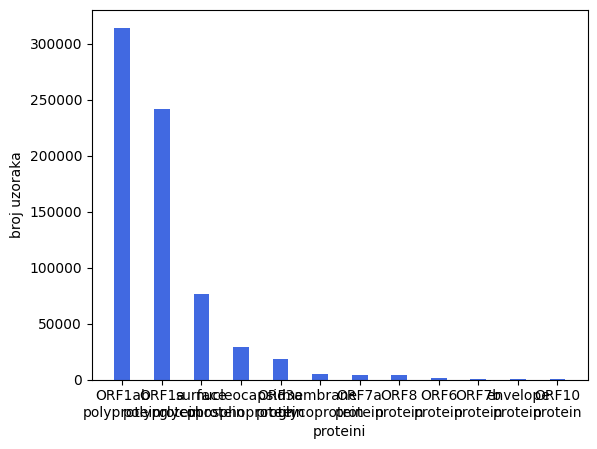

In [22]:
proteins = y_train.value_counts()

_ = plt.bar([a.replace(' ', '\n') for a in proteins.index], proteins[:], color='royalblue', width=0.4)

plt.xlabel('proteini')
plt.ylabel('broj uzoraka')

plt.show()

### Matrica korelacije i toplotna mapa

Korelacija je mera koja nam govori koliko su neka dva atributa linearno zavisna.
Matrica korelacije predstavlja tabelarni zapis korelacije svih atributa poparno.

Pozitivna korelacija ukazuje da ako vrednost jednog atributa raste, verovatno će rasti i vrednost drugog atributa.
Negativna korelacija da vrednost jednog atributa verovatno opada, ako vrednost drugog atributa raste i obrnuto.
Za atribute koji imaju korelaciju blizu nule, kažemo da nisu korelisani.
Za atribute koji imaju imaju korelaciju blizu 1 ili -1 kažemo da su jako korelisani.

Za problem klasifikacije želimo da atributi budu što slabije korelisani.
Jednostavniji klasifikatori čak polaze od pretpostavke da atributi nisu korelisani.

In [23]:
corr_matrix = X_train.corr()
corr_matrix.shape

(61, 61)

Pošto imamo 61 atribut, matrica korelacije je dimenzije 61x61, što i nije baš praktično za analizu.
Napravićemo toplotnu mapu, posebnu vrstu grafa za visokodimenzione podatke, koji dodeljuje boje numeričkim vrednostima, tako da svako polje u grafu odgovara jednom elementu matrice.
Polja koja odgovaraju negativno korelisanim atributima se boje crveno, a pozitivno korelisana polja žuto.
Nekorelisana i slabo korelisana polja će imati različite nijanse narandžaste.

Rezultat koji smo dobili je šaren.
Polja na dijagonali su jako korelisana, jer je svaki atribut potpuno korelisan sam sa sobom.
Matrica korelacije je simetrična, tako da je dovoljno da posmatramo trougao iznad, ili ispod dijagonale.
Očekivano, atributi koji odgovaraju kodonima koji kodiraju istu amino kiselinu su jako negativno korelisani.
Postoje atributi koji su i naizgled nasumično korelisani, kao što su atributi koji odgovaraju kodonima *ACG* i *CCG*.
Za objašnjenje takvih pojava potrebna su specifična domenska znanja.

Veliki deo tabele se nalazi u spektru narandžaste koji odgovara korelacijama od -0.5, do 0.5.

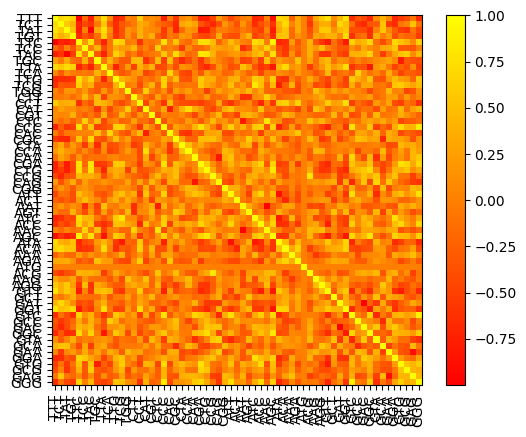

In [24]:
plt.imshow(corr_matrix, cmap='autumn')
plt.colorbar()

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.show()

### t-SNE

Stohastičko umetanje suseda sa t-raspodelim, kraće t-SNE, je nelinearni algoritam za dimenzionu redukciju.
Važna osobina algoritma je da čuva relativna rastojanja, tako da slične podatke sa velikom verovatnoćom projektuje u tačke koje se nalaze međusobno blizu, a različite podatke daleko.

Laurens van der Maaten je u svom radu preporučio da za parametar *perplexity* biramo vrednosti između 5 i 50.
Manje vrednosti previše naglašavaju lokalne strukture u podacima, dok veće vrednosti naglašavaju globalne strukture.
Pored toga, da bi algoritam konvergirao, neophodno je da dozvolimo veliki broj iteracija.
Zbog visoke dimenzionalnosti podataka biramo *Menhetn* rastojanje.

In [25]:
tsne = TSNE(n_components=2,
            perplexity=50,
            exaggeration=4,
            n_iter=10000,
            early_exaggeration_iter=1000,
            n_jobs=-1, metric='manhattan',
            learning_rate='auto',
            initialization='random',
            random_state=196883)

X_train_tsne = tsne.fit(X_train.to_numpy())

Klase se izdvajaju bez preklapanja, što je ohrabrujući rezultat i obećava dobru klasifikaciju.

Možemo primetiti da se unutar pojedinih klasa formira više klastera.
Takvo ponašanje može imati više uzroka.
Ili algoritam nije konvergirao do kraja, ili unutar tih klasa postoje podklase, odnosno podtipovi proteina.
Ispitivanje postojanja podtipova proteina zahteva domensko znanje.
Ispitivanje konvergencije je zahtevno, jer sam algoritam ima kvadratnu složenost i zasnovan je na problemima koji nemaju analitičko rešenje.

Zadovoljićemo se činjenicom da se klase dobro izdvajaju bez preklapanja instanci.

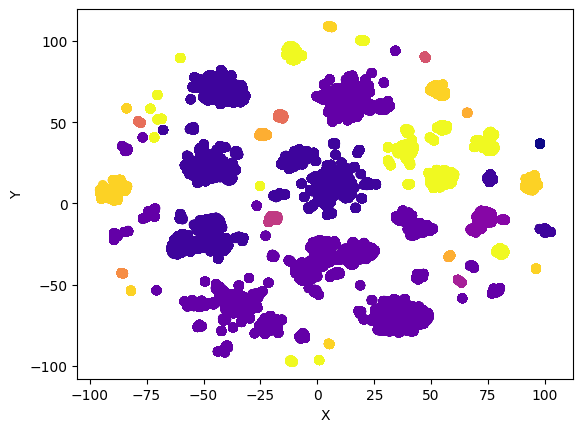

In [26]:
_ = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=enc.transform(y_train), cmap='plasma')

plt.xlabel('X')
plt.ylabel('Y')

plt.show()

## Treniranje i evaluacija modela

Za isbor modela koristićemo unakrsnu validaciju sa iscrpnom pretragom.
Za svaki algoritam određujemo skup parametara u kome smatramo da se nalaze parametri za optimalan model.
Trening podaci se dele na više svitaka, tako da za određenu kombinaciju parametara jedan svitak se koristi za validaciju, a ostali za trening.
Skupovi sa validaciju su u lokalnom smislu test skupovi.
Na kraju, na osnovu zadate metrike, bira se najbolji model.
Izbor metrike može znatno uticati na kvalitet modela.

Za sve algoritme, u unakrsnoj validaciji ćemo koristiti metriku balansirane tačnosti.

Obična tačnost se računa kao $\frac{broj\_tačno\_klasifikovanih\_instanci}{ukupan\_broj\_instanci}$ .
To ne daje validan rezultat u slučaju neuravnoteženih podataka.
U podacima sa kojima raspolažemo imamo 12 klasa, dok najveći broj instanci se nalazi u dve klase.
Model koji dobro klasifikuje samo te dve klase će biti dobro ocenjen, čak ako instance preostalih deset klasa klasifikuje pogrešno.

Balansirana tačnost računa tačnost za svaku klasu po formuli $\frac{broj\_tačno\_klasifikovanih\_instanci\_klase}{ukupan\_broj\_instanci\_dane\_klase}$ .
Nakon izračunavanja tačnosti za sve klase, uzima se njihov prosek i ta vrednost je balansirana tačnost datog modela.
Na taj način je eliminisan uticaj neuravnoteženosti podataka.

### Komplementarni naivni Bajesov algoritam

Naivni Bajesov algoritam funkcioniše tako što izračunava verovatnoću da instanca pripada određenoj klasi sa zadatom kombinacijom atributa.
Komplementarna varijacija algoritma računa verovatnoću da instanca ne pripada klasi i dodeljuje je onoj klasi sa najmanjom izračunatom verovatnoćom nepripadnosti.
Autori algoritma tvrde da se na taj način umanjuje uticaj neuravnoteženosti podataka.

Algoritam pretpostavlja da su svi atributi poparno nezavisni.
Iz matrice korelacije možemo videti da to i nije baš slučaj.
U cilju prevazilaženja tog problema, u implementaciji je ugrađen i algoriam za aditivno uglađivanje podataka.
U idealnom slučaju, za parametar *alpha* bi isprobali sve varijacije sa ponavljanjem određenog skupa vrednosti, kako bi našli optimalne vrednosti za svaki atribut.
Takva pretraga bi bila eksponencijalne složenosti, pa bi svrsishodnije bilo isprobati drugi algoritam ukoliko ovaj ne da željene rezultate.

In [27]:
params = [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000, 10000]}]

In [ ]:
clf = GridSearchCV(ComplementNB(), params, scoring='balanced_accuracy', n_jobs=-1, cv=5)
_ = clf.fit(X_train, y_train)

Ocena najboljeg modela.

In [ ]:
clf.best_score_

0.5401268913912329

Parametri najboljeg modela.

In [ ]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

alpha,force_alpha
0.000000,True


Izveštaj za trening skup.

In [ ]:
print('izvestaj za trening skup')

y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       0.00      0.00      0.00       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       0.94      1.00      0.97     18476
               ORF6 protein       0.00      0.00      0.00      1098
              ORF7a protein       1.00      0.87      0.93      3937
              ORF7b protein       0.00      0.00      0.00       743
               ORF8 protein       1.00      0.61      0.76      3831
           envelope protein       0.00      0.00      0.00       658
      membrane glycoprotein       0.00      0.00      0.00      5083
nucleocapsid phosphoprotein       0.83      1.00      0.91     29103
       surface glycoprotein       0.99      1.00      0.99     76782

                   accuracy                           0.99    695886
       

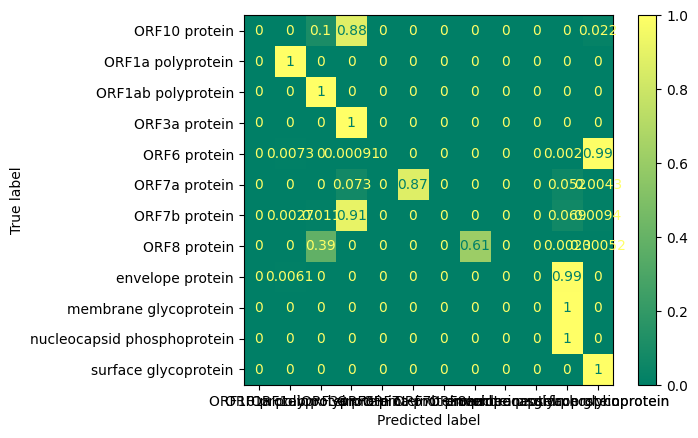

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

Izveštaj za test skup.

In [ ]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       0.00      0.00      0.00        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       0.99      1.00      1.00     78610
              ORF3a protein       0.93      1.00      0.97      4619
               ORF6 protein       0.00      0.00      0.00       274
              ORF7a protein       1.00      0.87      0.93       984
              ORF7b protein       0.00      0.00      0.00       186
               ORF8 protein       1.00      0.59      0.74       958
           envelope protein       0.00      0.00      0.00       164
      membrane glycoprotein       0.00      0.00      0.00      1271
nucleocapsid phosphoprotein       0.83      1.00      0.91      7276
       surface glycoprotein       0.99      1.00      0.99     19196

                   accuracy                           0.99    173972
          

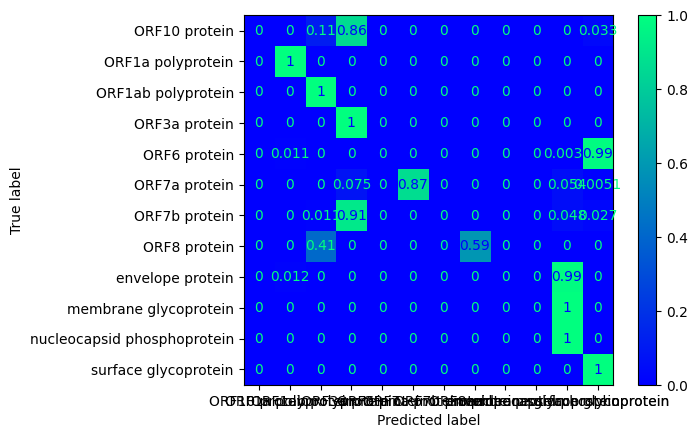

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

### Pakovanje naivnog Bajesovog algoritma

Rezultati koje je dao naivni Bajesov algoritam nisu bili impresivni, ali da li možemo da ih popravimo metodama ansambla?
Pakovanje je metoda ansambla koja koristi više slabih klasifikatora koji se obično ne obučavaju nad celim skupom podataka, već nad nasumičnim uzorcima sa ponavljanjem.
Algoritam dodeljuje instanci onu klasu koju je izabrao najveći broj klasifikatora.

Probaćemo sa različitim brojem klasifikatora i različitim maksimalnim veličinama uzorka.

In [ ]:
params = [{'estimator': [ComplementNB()],
           'n_estimators': [64, 128, 256, 512],
           'max_samples': [0.0001, 0.001, 0.01, 0.1],
           'oob_score': [False, True],
           'n_jobs': [-1],
           'random_state': [196883]}]

In [ ]:
clf = GridSearchCV(BaggingClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, y_train)

Ocena najboljeg modela.

In [ ]:
clf.best_score_

0.5533204155898793

Parametri najboljeg modela.

In [ ]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

estimator,max_features,max_samples,n_estimators,n_jobs,random_state
"ComplementNB(alpha=0.0, force_alpha=True)",0.400000,0.200000,128,-1,196883


Izveštaj za trening skup.

In [ ]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       0.00      0.00      0.00       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       0.94      1.00      0.97     18476
               ORF6 protein       0.00      0.00      0.00      1098
              ORF7a protein       1.00      0.84      0.92      3937
              ORF7b protein       0.00      0.00      0.00       743
               ORF8 protein       1.00      0.79      0.88      3831
           envelope protein       0.00      0.00      0.00       658
      membrane glycoprotein       0.00      0.00      0.00      5083
nucleocapsid phosphoprotein       0.83      1.00      0.90     29103
       surface glycoprotein       0.99      1.00      0.99     76782

                   accuracy                           0.99    695886
       

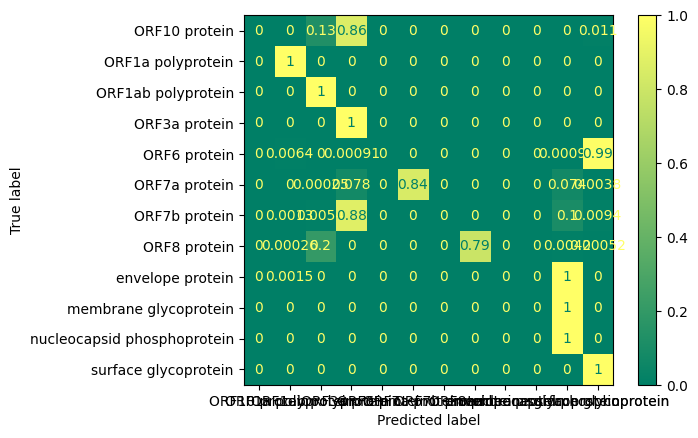

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

Izveštaj za test skup.

In [ ]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       0.00      0.00      0.00        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       1.00      1.00      1.00     78610
              ORF3a protein       0.94      1.00      0.97      4619
               ORF6 protein       0.00      0.00      0.00       274
              ORF7a protein       1.00      0.85      0.92       984
              ORF7b protein       0.00      0.00      0.00       186
               ORF8 protein       1.00      0.78      0.87       958
           envelope protein       0.00      0.00      0.00       164
      membrane glycoprotein       0.00      0.00      0.00      1271
nucleocapsid phosphoprotein       0.83      1.00      0.91      7276
       surface glycoprotein       0.99      1.00      0.99     19196

                   accuracy                           0.99    173972
          

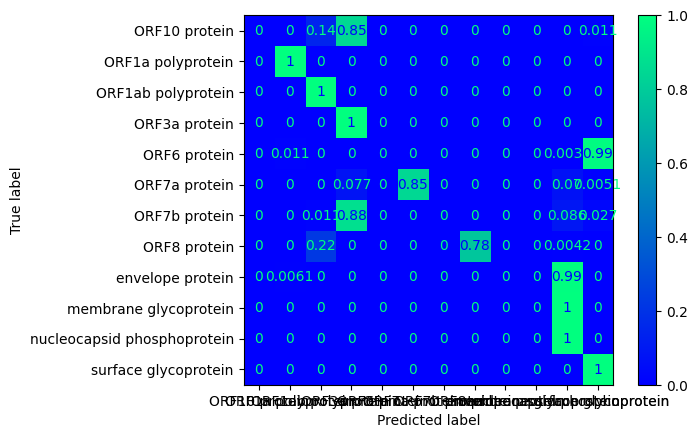

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

### Stablo odlučivanja

Naivni Bajesov algoritam nije dao značajne rezultate.
Vreme je da isprobamo nešto potpuno drugačije.
Algoritam CART.

Izabraćemo dva pristupa za unakrsnu validaciju.
U jednom ćemo varirati parametre za maksimalnu dubinu stable i minimalan broj uzoraka u čvoru za podelu i list.
U drugom pristupu umesto konstantnih ograničenja, koristićemo minimalno smanjenje nečistoće za podelu i potkresivanje.
U oba slučaja proveravaćemo da li ginijev indeks ili entropija daju bolje rezultate za informacionu dobit.

In [ ]:
params = [{'criterion': ['gini', 'entropy'],
            'max_depth': [4, 8, 16, 32],
            'min_samples_split': [128, 256],
            'min_samples_leaf': [32, 64],
            'max_features': ['auto'],
            'class_weight': [balanced],
            'random_state': [196883]},
          {'criterion': ['gini', 'entropy'],
            'min_impurity_decrease': [0.01, 0.02, 0.03, 0.04],
            'ccp_alpha': [0.01, 0.02, 0.03, 0.04],
            'max_features': ['auto'],
            'class_weight': [balanced],
            'random_state': [196883]}]

In [ ]:
clf = GridSearchCV(DecisionTreeClassifier(), params, scoring='balanced_accuracy', n_jobs=-1, cv=5)
_ = clf.fit(X_train, y_train)

Ocena najboljeg modela obećava.

In [ ]:
clf.best_score_

0.991189322460462

Parametri najboljeg modela.

In [ ]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

criterion,max_depth,min_samples_leaf,min_samples_split,random_state
entropy,16,32,128,196883


Grafički prikaz stabla odlučivanja.
Veliki listovi su čisti čvorovi i svaka klasa ima svoj veliki list.
Listovi niže čistoće sadrže dvocifrene brojeve instanci i ne zadovoljavaju kriterijume minimalnog broja instanci u čvoru za deobu ili minimalnog broja instanci u čvoru da bi bio list.

c:\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


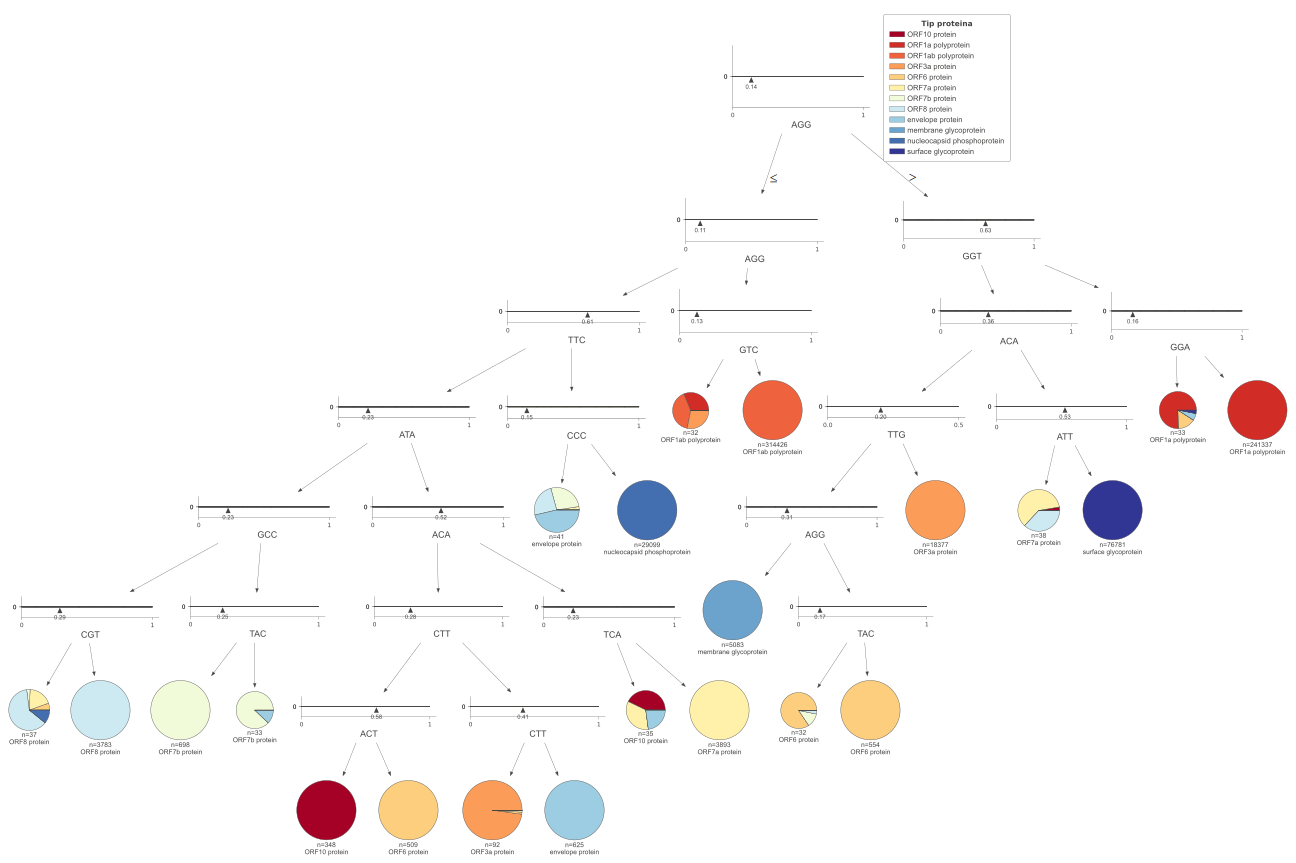

In [ ]:
viz = dtreeviz(DecisionTreeClassifier(criterion=clf.best_params_['criterion'],
                                      max_depth=clf.best_params_['max_depth'],
                                      min_samples_leaf=clf.best_params_['min_samples_leaf'],
                                      min_samples_split=clf.best_params_['min_samples_split'],
                                      max_features=clf.best_params_['max_features'],
                                      class_weight=clf.best_params_['class_weight']
                                      random_state=clf.best_params_['random_state']),
               x_data=X_train.to_numpy(), y_data=enc.transform(y_train),
               feature_names=X_train.columns.to_numpy(),
               target_name='Tip proteina',
               class_names=list(clf.best_estimator_.classes_))

viz

Izveštaj i normalizovana matrica konfuzije za trening skup podataka.

In [ ]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       0.95      1.00      0.97       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       1.00      1.00      1.00     18476
               ORF6 protein       1.00      0.99      0.99      1098
              ORF7a protein       1.00      0.99      1.00      3937
              ORF7b protein       0.99      0.98      0.99       743
               ORF8 protein       1.00      0.99      0.99      3831
           envelope protein       0.97      0.98      0.97       658
      membrane glycoprotein       1.00      1.00      1.00      5083
nucleocapsid phosphoprotein       1.00      1.00      1.00     29103
       surface glycoprotein       1.00      1.00      1.00     76782

                   accuracy                           1.00    695886
       

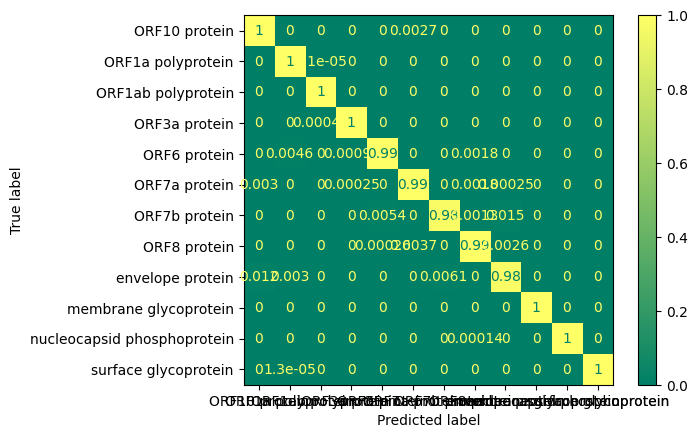

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

Izveštaj i normalizovana matrica konfuzije za test skup podataka.

In [ ]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       0.95      0.99      0.97        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       1.00      1.00      1.00     78610
              ORF3a protein       1.00      1.00      1.00      4619
               ORF6 protein       0.99      0.99      0.99       274
              ORF7a protein       0.99      1.00      1.00       984
              ORF7b protein       0.98      0.98      0.98       186
               ORF8 protein       1.00      0.99      0.99       958
           envelope protein       0.97      0.96      0.97       164
      membrane glycoprotein       1.00      1.00      1.00      1271
nucleocapsid phosphoprotein       1.00      1.00      1.00      7276
       surface glycoprotein       1.00      1.00      1.00     19196

                   accuracy                           1.00    173972
          

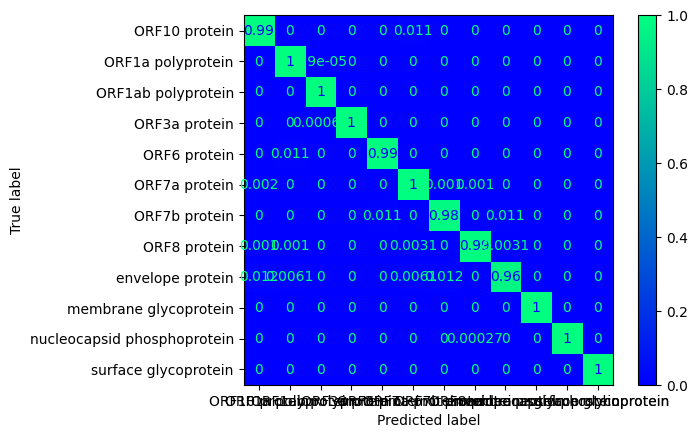

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

### Nasumična šuma

Metoda slična pakovanju.
Klasifikatori su stabla odlučivanja koja se obučavaju na nasumično izabranim uzorcima atributa i instanci.
Slično kao u pakovanju, izlaz algoritma je klasa koju je izabrao najveći broj stabala odlučivanja.

Unakrsnom validacijom ćemo testirati modele sa različitim brojem klasifikatora i najvećim dozvoljenim brojevima atributa i instanci u uzorcima.
Pustićemo da se stabla preprilagode.

In [ ]:
params = [{'n_estimators': [32, 64, 128, 256],
           'criterion': ['entropy'],
           'max_features': [0.4, 0.6],
           'max_samples': [0.4, 0.6],
           'n_jobs': [-1],
           'random_state': [196883]}]

In [ ]:
clf = GridSearchCV(RandomForestClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, y_train)

Ocena najboljeg modela.

In [ ]:
clf.best_score_

0.9999014273894076

Parametri najboljeg modela.

In [ ]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

criterion,max_features,max_samples,n_estimators,n_jobs,random_state
entropy,0.400000,0.400000,128,-1,196883


Izveštaj i normalizovana matrica konfuzije za trening skup podataka.

In [ ]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      1.00      1.00       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       1.00      1.00      1.00     18476
               ORF6 protein       1.00      1.00      1.00      1098
              ORF7a protein       1.00      1.00      1.00      3937
              ORF7b protein       1.00      1.00      1.00       743
               ORF8 protein       1.00      1.00      1.00      3831
           envelope protein       1.00      1.00      1.00       658
      membrane glycoprotein       1.00      1.00      1.00      5083
nucleocapsid phosphoprotein       1.00      1.00      1.00     29103
       surface glycoprotein       1.00      1.00      1.00     76782

                   accuracy                           1.00    695886
       

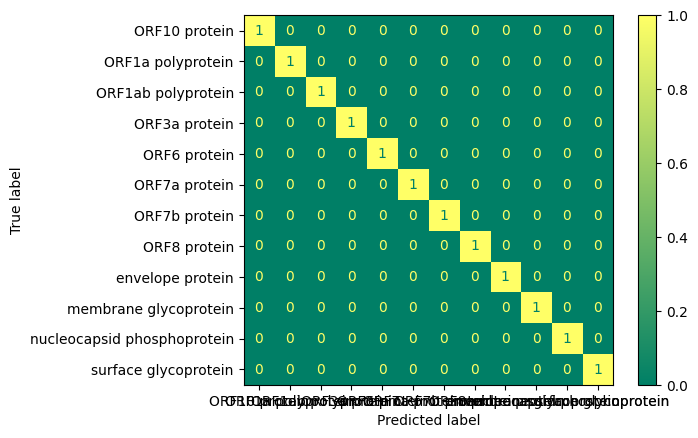

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

Izveštaj i normalizovana matrica konfuzije za test skup podataka.

In [ ]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      1.00      1.00        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       1.00      1.00      1.00     78610
              ORF3a protein       1.00      1.00      1.00      4619
               ORF6 protein       1.00      1.00      1.00       274
              ORF7a protein       1.00      1.00      1.00       984
              ORF7b protein       1.00      1.00      1.00       186
               ORF8 protein       1.00      1.00      1.00       958
           envelope protein       1.00      1.00      1.00       164
      membrane glycoprotein       1.00      1.00      1.00      1271
nucleocapsid phosphoprotein       1.00      1.00      1.00      7276
       surface glycoprotein       1.00      1.00      1.00     19196

                   accuracy                           1.00    173972
          

Ovaj model je praktično savršen.

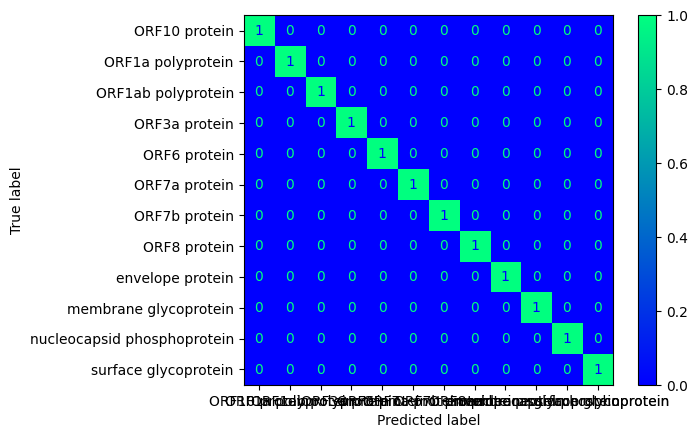

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

### Ekstremno gradijentno pojačavanje stabala odlučivanja

Slično opštoj metodi pojačavanja, klasifikacija se vrši iterativno, kombinacijom više slabih, potprilagođenih klasifikatora, da bi se dobio jedan moćan klasifikator.
Instancama koje klasifikator ne klasifikuje ispravno u trenutnoj iteraciji dodeljuje se veća težina.
Klasifikator u narednoj iteraciji obraća više pažnje na pravilno klasifikovanje instanci koje prethodno nisu bile ispravno klasifikovane.

Za razliku od ostalih algoritama pojačavanja, algoritam dozvoljava optimizaciju proizvoljne diferencijabilne funkcije cene i umesto gradijentnog spusta koristi Njutnovu metodu za optimizaciju funkcije cene.
Tejlorov razvoj drugog reda se koristi da bi se dobila veza funkcije cene i Njutnove metode.

Algoritam koristi stabla odlučivanja za slabe klasifikatore i implementiran je tako da se efikasno paralelizuje i iskoristi kapacitete savremenih računara.

Unakrsnom validacijom ćemo izabrati najbolji model varirajući broj klasifikatora, maksimalnu dubinu stabala odlučivanja i stopu učenja.

In [ ]:
params = [{'n_estimators': [32, 64, 128],
           'max_depth': [2, 4],
           'learning_rate': [0.01, 0.1, 0.2],
           'objective': ['reg:linear'],
           'nthread': [-1],
           'random_state': [196883]}]

In [ ]:
clf = GridSearchCV(XGBClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, enc.transform(y_train))

Ocena najboljeg klasifikatora je za nijansu slabija od klasifikatora iz nasumične šume.

In [ ]:
clf.best_score_

0.9997906559182297

Parametri najboljeg modela.

In [ ]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

learning_rate,max_depth,n_estimators,nthread,objective,random_state
0.100000,2,64,-1,reg:linear,196883


Izveštaj i normalizovana matrica konfuzije za trening skup podataka.

In [ ]:
y_true, y_pred = y_train, enc.inverse_transform(clf.predict(X_train))
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      1.00      1.00       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       1.00      1.00      1.00     18476
               ORF6 protein       1.00      1.00      1.00      1098
              ORF7a protein       1.00      1.00      1.00      3937
              ORF7b protein       1.00      1.00      1.00       743
               ORF8 protein       1.00      1.00      1.00      3831
           envelope protein       1.00      1.00      1.00       658
      membrane glycoprotein       1.00      1.00      1.00      5083
nucleocapsid phosphoprotein       1.00      1.00      1.00     29103
       surface glycoprotein       1.00      1.00      1.00     76782

                   accuracy                           1.00    695886
       

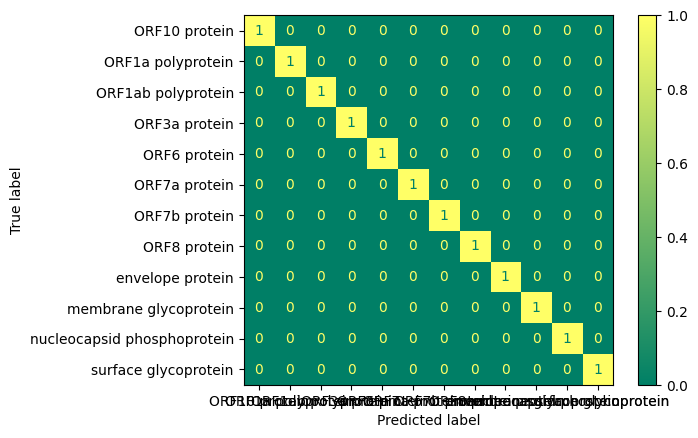

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

Izveštaj i normalizovana matrica konfuzije za test skup podataka.

In [ ]:
y_true, y_pred = y_test, enc.inverse_transform(clf.predict(X_test))
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      1.00      1.00        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       1.00      1.00      1.00     78610
              ORF3a protein       1.00      1.00      1.00      4619
               ORF6 protein       1.00      1.00      1.00       274
              ORF7a protein       1.00      1.00      1.00       984
              ORF7b protein       1.00      1.00      1.00       186
               ORF8 protein       1.00      1.00      1.00       958
           envelope protein       1.00      1.00      1.00       164
      membrane glycoprotein       1.00      1.00      1.00      1271
nucleocapsid phosphoprotein       1.00      1.00      1.00      7276
       surface glycoprotein       1.00      1.00      1.00     19196

                   accuracy                           1.00    173972
          

I ovaj model praktično klasifikuje bez greške.

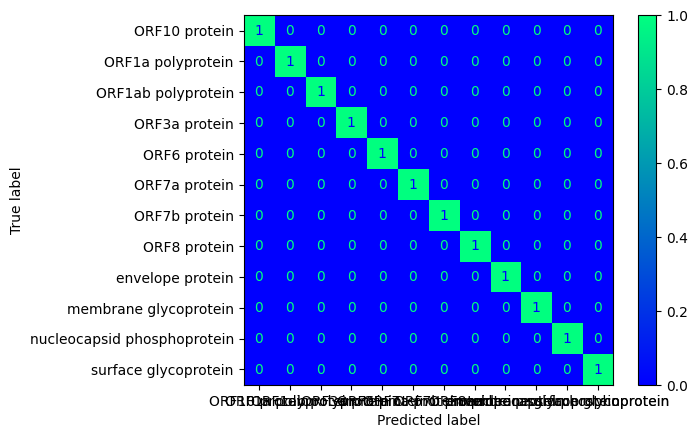

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

### Linearna mašina sa potpornim vektorima

Već smo dobili dva modela koji praktično ne greše.
Da bi zadovoljili radoznalost, napravićemo još jedan.

Algoritam traži hiperravni koje razdvajaju podatke na klase.
Tražimo najbolje parametre za regularizaciju i skaliranje.
Prosleđujemo argument kojim ukazujemo algoritmu da klasama dodeli težine.
Na taj način rešavamo problem neuravnoteženosti podataka.

Parametar za regularizaciju utiče na cenu pogrešno klasifikovane instance.
Što je parametar veći, mogel će oštrije ocenjivati nepravilno klasifikovane instance.
Što je parametar manji, model će više tolerisati nepravilno klasifikovane instance.
Parametar se ponaša kao neka vrsta dozvoljene margine, koliko daleko podaci mogu da se nalaze sa pogrešne strane hiperravni.

Algoritam interno vrši standardizaciju podataka.
U te svrhe koristi i parametar skaliranja.
To je multiplikativni faktor i utiče na težinu atributa prilikom ocenjivanja nepravilno klasifikovane instance.

In [ ]:
params = [{'dual': ['auto'],
           'C': [0.1, 1, 10, 100],
           'intercept_scaling': [0.01, 0.1, 1, 10],
           'class_weight': ['balanced'],
           'max_iter': [2147483647],
           'random_state': [196883]}]

In [ ]:
clf = GridSearchCV(LinearSVC(), params, scoring='balanced_accuracy', n_jobs=-1, cv=5)
_ = clf.fit(X_train, y_train)

Najbolji dobijeni model ima nešto slabiji skor od metode ansambla, ali bolji od stabla odlučivanja.

In [ ]:
clf.best_score_

0.9996634294551253

Parametri najboljeg modela.

In [ ]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

C,class_weight,dual,fit_intercept,intercept_scaling,max_iter,penalty,random_state
10,balanced,auto,True,0.000100,2147483647,l2,196883


Izveštaj i normalizovana matrica konfuzije za trening skup podataka.

In [ ]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      1.00      1.00       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       1.00      1.00      1.00     18476
               ORF6 protein       1.00      1.00      1.00      1098
              ORF7a protein       1.00      1.00      1.00      3937
              ORF7b protein       1.00      1.00      1.00       743
               ORF8 protein       1.00      1.00      1.00      3831
           envelope protein       1.00      1.00      1.00       658
      membrane glycoprotein       1.00      1.00      1.00      5083
nucleocapsid phosphoprotein       1.00      1.00      1.00     29103
       surface glycoprotein       1.00      1.00      1.00     76782

                   accuracy                           1.00    695886
       

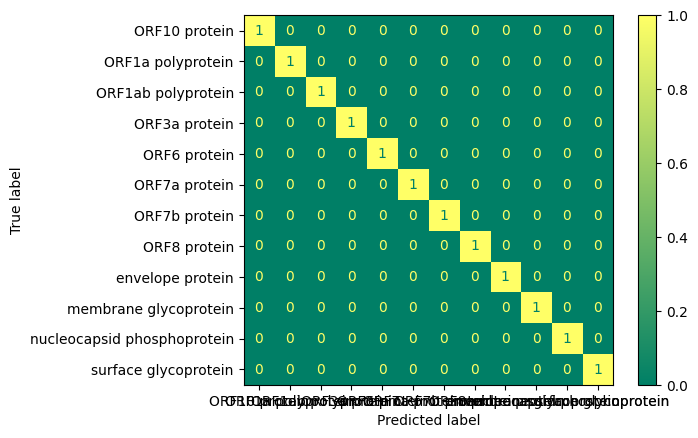

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

Izveštaj i normalizovana matrica konfuzije za test skup podataka.

In [ ]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      0.99      0.99        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       1.00      1.00      1.00     78610
              ORF3a protein       1.00      1.00      1.00      4619
               ORF6 protein       1.00      1.00      1.00       274
              ORF7a protein       1.00      1.00      1.00       984
              ORF7b protein       1.00      1.00      1.00       186
               ORF8 protein       1.00      1.00      1.00       958
           envelope protein       1.00      1.00      1.00       164
      membrane glycoprotein       1.00      1.00      1.00      1271
nucleocapsid phosphoprotein       1.00      1.00      1.00      7276
       surface glycoprotein       1.00      1.00      1.00     19196

                   accuracy                           1.00    173972
          

Model je blago preprilagođen.
Pogrešno klasifikuje deo instanci *ORF10* proteina kao *ORF1ab* protein.

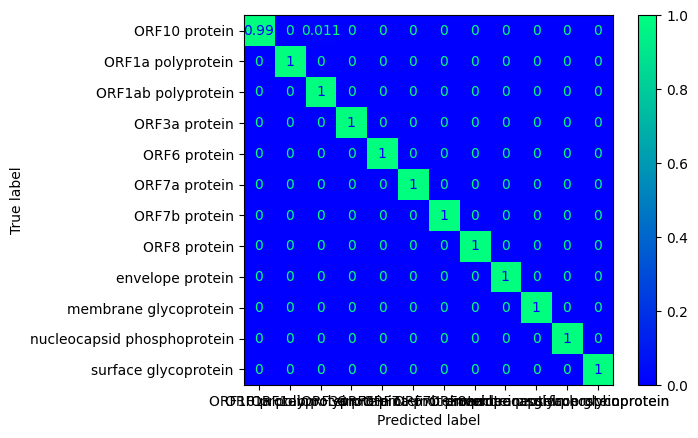

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

## Zaključak